In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
# import seaborn as sns

import pandas as pd
import numpy as np
import math

from tensorflow.keras.models import load_model

import mdn
import joblib

# from sklearn.model_selection import train_test_split

import matplotlib
matplotlib.rcParams['svg.fonttype'] = 'none'
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'Arial'
matplotlib.rcParams['font.size'] = 12

# MRFe/(Mg+Si)k2 prediction

In [2]:
input_parameters = [
    'Mass', 
    'Radius',
    'Fe/(Mg+Si)',
    'k_2',
]

output_parameters = [
    'H2O_radial_frac',
    'Mantle_radial_frac',
    'Core_radial_frac',
    'Core_mass_frac',
    'P_CMB', 
    'T_CMB',
]
# load trained model and scaler
OUTPUT_DIMS = len(output_parameters)
N_MIXES = 20
model = load_model(
    "MDN_MRFe(Mg+Si)k2_20220917.h5", 
    custom_objects={"MDN": mdn.MDN(OUTPUT_DIMS, N_MIXES), "mdn_loss_func": mdn.get_mixture_loss_func(OUTPUT_DIMS,N_MIXES)},
    compile=False
)
input_scaler = joblib.load("MDN_MRFe(Mg+Si)k2_Xscaler_20220917.save")
output_scaler = joblib.load("MDN_MRFe(Mg+Si)k2_yscaler_20220917.save")


ModuleNotFoundError: No module named 'sklearn'

## Predict Kepler-78b

### MDN model

In [3]:
# input mass and radius for predicting must be earth units
input_array = np.array(
    [
        [1.77],  # mass
        [1.228],  # radius
        [0.685],  # bulk Fe/(Mg+Si)
        [0.819],  # k2
    ]
)
scaled_input = input_scaler.transform(input_array.T)

In [4]:
pred = model.predict(scaled_input)
# # pred contains parameters for distributions, not actual points on the graph.
# print(pred)
# print(pred.shape)

In [5]:
y_min1,y_max1,y_min2,y_max2,y_min3,y_max3,y_min4,y_max4,y_min5,y_max5,y_min6,y_max6 = \
0.00015137, 0.145835, 0.127618, 0.973427, 0.00787023, 0.799449, 1.17976e-06, 0.699986, 10.7182, 1999.49, 1689.37, 5673.87

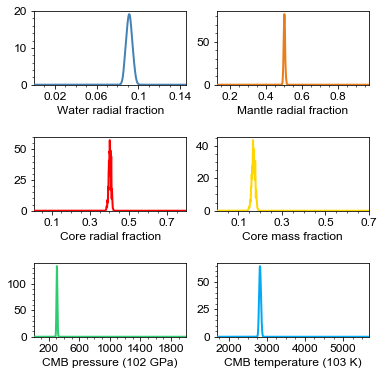

In [6]:
# split up the mixture parameters
mus = np.apply_along_axis((lambda a: a[:N_MIXES*OUTPUT_DIMS]), 1, pred)
sigs = np.apply_along_axis((lambda a: a[N_MIXES*OUTPUT_DIMS:2*N_MIXES*OUTPUT_DIMS]), 1, pred)
pis = np.apply_along_axis((lambda a: mdn.softmax(a[-N_MIXES:])), 1, pred)

for m in range(OUTPUT_DIMS):
    locals()['mus'+str(m)] = []
    locals()['sigs'+str(m)] = []
#     print(m)
    for n in range(20):
#         print(n)
        locals()['mus'+str(m)].append(mus[0][n*OUTPUT_DIMS + m])
        locals()['sigs'+str(m)].append(sigs[0][n*OUTPUT_DIMS + m])



x_max = [
    1,
    1,
    1,
    1,
    1,
    1,
]
x_maxlabels = [
    y_min1+(y_max1-y_min1)*x_max[0],
    y_min2+(y_max2-y_min2)*x_max[1],
    y_min3+(y_max3-y_min3)*x_max[2],
    y_min4+(y_max4-y_min4)*x_max[3],
    y_min5+(y_max5-y_min5)*x_max[4],
    y_min6+(y_max6-y_min6)*x_max[5],
]

wrf = []  # H2O_radial_frac
mrf = []  # Mantle_radial_frac
crf = []  # Core_radial_frac
cmf = []  # Core mass frac
pcmb = []  # CMB temperature
tcmb = []  # CMB pressure


for x1 in np.arange(0.02,0.15,0.04):
    wrf.append((x1-y_min1)/(x_maxlabels[0]-y_min1)*x_max[0])
for x2 in np.arange(0.2,1,0.2):
    mrf.append((x2-y_min2)/(x_maxlabels[1]-y_min2)*x_max[1])
for x3 in np.arange(0.1,0.9,0.2):
    crf.append((x3-y_min3)/(x_maxlabels[2]-y_min3)*x_max[2])
for x4 in np.arange(0.1,0.8,0.2):
    cmf.append((x4-y_min4)/(x_maxlabels[3]-y_min4)*x_max[3])
for x5 in np.arange(200, 2000, 400):
    pcmb.append((x5-y_min5)/(x_maxlabels[4]-y_min5)*x_max[4])
for x6 in np.arange(2000, 6000, 1000):
    tcmb.append((x6-y_min6)/(x_maxlabels[5]-y_min6)*x_max[5])
    
xticklabels = [[round(x,2) for x in np.arange(0.02,0.15,0.04)],
               [round(x,2) for x in np.arange(0.2,1,0.2)],
               [round(x,2) for x in np.arange(0.1,0.9,0.2)],
               [round(x,2) for x in np.arange(0.1,0.8,0.2)],
               [round(x,2) for x in np.arange(200, 2000, 400)],
               [round(x,2) for x in np.arange(2000, 6000, 1000)],
              ]
xticks = [wrf, mrf, crf, cmf, pcmb, tcmb]

colors = [
    "steelblue",
    "#EA7D1A",
    "red", 
    "gold", 
    "#2ecc71",
    "#03a9f4"
]
predict_label = [
    "Water radial fraction", 
    "Mantle radial fraction",
    "Core radial fraction", 
    "Core mass fraction", 
    "CMB pressure (102 GPa)", 
    "CMB temperature (103 K)"
]


y_label = np.arange(0,1,0.001).reshape(-1,1)
fig = plt.figure(figsize=(6,6))
fig.subplots_adjust(hspace=0.7, wspace=0.2)
for i in range(OUTPUT_DIMS):
    ax = fig.add_subplot(3, 2, i+1)
    # y_label = y_labels[:, i].reshape(-1,1)
    # for i, label in zip(range(OUTPUT_DIMS), predict_label):
#     fig, ax = plt.subplots(figsize=(8,4))
    # label = "Water radial fraction"
    ###################Earth###########################
    mus_ = np.array(locals()['mus'+str(i)])
    sigs_ = np.array(locals()['sigs'+str(i)])
    factors = 1 / math.sqrt(2*math.pi) / sigs_
    exponent = np.exp(-1/2*np.square((y_label-mus_)/sigs_))
    GMM_PDF = np.sum(pis[0]*factors*exponent, axis=1); # 对多个高斯分布求和
    plt.plot(
        y_label, 
        GMM_PDF,
        color=colors[i],
#         label=label,
        lw=2,
        zorder=10,
    )
    ax.set_xlim(0, x_max[i])
    ax.set_ylim(bottom=0)
    
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
#     print(xticks[i])
#     xticklabels[i]
    ax.set_xticks(xticks[i])
    ax.set_xticklabels(xticklabels[i])
    ax.set_xlabel(predict_label[i])
#     ax.set_ylabel("Probability density")
# plt.tight_layout()
# plt.savefig('MRCk2_mdn_pred_Kepler-78b_20220925.pdf')

### Physical model

In [9]:
df_k = pd.read_csv('Kepler 78b.txt', sep='\t')
df_k.drop(columns=df_k.columns[0], inplace=True)  # delete useless column 0


0.145835
0.973427
0.799449
0.699986
1999.49
5673.87


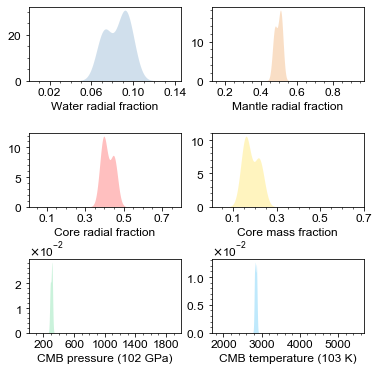

In [10]:
df_k1 = df_k[df_k['sigma_MRCk2']<=0.02]

inputs = ['Mass Earth_mass', 'Radius Earth_radius', 'Fe/(Si+Mg)', 'static Love number k2']
outputs = ['water radial frac', 'mantle radial frac', 'core radial frac', 'core mass frac', 'CMB press (GPa)', 'CMB temp (K)']


x_max = [
    1,
    1,
    1,
    1,
    1,
    1,
]
x_maxlabels = [
    y_min1+(y_max1-y_min1)*x_max[0],
    y_min2+(y_max2-y_min2)*x_max[1],
    y_min3+(y_max3-y_min3)*x_max[2],
    y_min4+(y_max4-y_min4)*x_max[3],
    y_min5+(y_max5-y_min5)*x_max[4],
    y_min6+(y_max6-y_min6)*x_max[5],
]

wrf = []  # H2O_radial_frac
mrf = []  # Mantle_radial_frac
crf = []  # Core_radial_frac
cmf = []  # Core mass frac
pcmb = []  # CMB temperature
tcmb = []  # CMB pressure


for x1 in np.arange(0.02,0.15,0.04):
    wrf.append((x1-y_min1)/(x_maxlabels[0]-y_min1)*x_max[0])
for x2 in np.arange(0.2,1,0.2):
    mrf.append((x2-y_min2)/(x_maxlabels[1]-y_min2)*x_max[1])
for x3 in np.arange(0.1,0.9,0.2):
    crf.append((x3-y_min3)/(x_maxlabels[2]-y_min3)*x_max[2])
for x4 in np.arange(0.1,0.8,0.2):
    cmf.append((x4-y_min4)/(x_maxlabels[3]-y_min4)*x_max[3])
for x5 in np.arange(200, 2000, 400):
    pcmb.append((x5-y_min5)/(x_maxlabels[4]-y_min5)*x_max[4])
for x6 in np.arange(2000, 6000, 1000):
    tcmb.append((x6-y_min6)/(x_maxlabels[5]-y_min6)*x_max[5])
    
xticklabels = [[round(x,2) for x in np.arange(0.02,0.15,0.04)],
               [round(x,2) for x in np.arange(0.2,1,0.2)],
               [round(x,2) for x in np.arange(0.1,0.9,0.2)],
               [round(x,2) for x in np.arange(0.1,0.8,0.2)],
               [round(x,2) for x in np.arange(200, 2000, 400)],
               [round(x,2) for x in np.arange(2000, 6000, 1000)],
              ]
xticks = [wrf, mrf, crf, cmf, pcmb, tcmb]
fig = plt.figure(figsize=(6,6))

fig.subplots_adjust(hspace=0.7, wspace=0.2)

x_max = [
    y_min1+(y_max1-y_min1)*1,
    y_min2+(y_max2-y_min2)*1,
    y_min3+(y_max3-y_min3)*1,
    y_min4+(y_max4-y_min4)*1,
    y_min5+(y_max5-y_min5)*1,
    y_min6+(y_max6-y_min6)*1,
]
for f in range(0,6):
    ax = fig.add_subplot(3, 2, f+1)
    y_min = locals()['y_min'+str(f+1)]
    y_max = locals()['y_max'+str(f+1)]
    print(y_max)
    sns.kdeplot(df_k1[outputs[f]], color=colors[f],fill=True,linewidth=0,bw_adjust=1,)
    ax.set_xlim(y_min, y_max)
    ax.set_ylim(bottom=0)
    
#     print(xticks[i])
#     xticklabels[i]

    ax.set_xticks(xticklabels[f])
#     ax.set_xticklabels(xticklabels[f])
    ax.set_xlabel(predict_label[f])
    ax.set_ylabel(None)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    formatter = tck.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True) 
    formatter.set_powerlimits((-2,2))
    ax.yaxis.set_major_formatter(formatter)
# plt.tight_layout()
# plt.savefig('MRCk2_phy_pred_Kepler-78b_20220925.pdf')

## Predict HD3167b

### MDN model

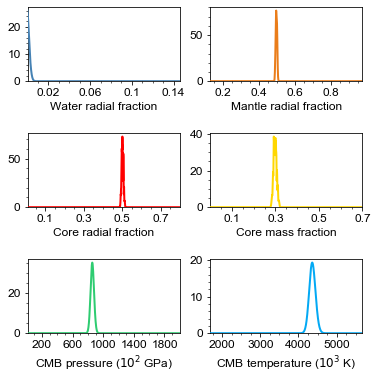

In [11]:
# input mass and radius for predicting must be earth units
input_array2 = np.array(
    [
        [5.69],  # mass
        [1.574],  # radius
        [0.630],  # bulk Fe/(Mg+Si)
        [0.854],  # k2
    ]
)
scaled_input2 = input_scaler.transform(input_array2.T)

pred2 = model.predict(scaled_input2)


# split up the mixture parameters
mus = np.apply_along_axis((lambda a: a[:N_MIXES*OUTPUT_DIMS]), 1, pred2)
sigs = np.apply_along_axis((lambda a: a[N_MIXES*OUTPUT_DIMS:2*N_MIXES*OUTPUT_DIMS]), 1, pred2)
pis = np.apply_along_axis((lambda a: mdn.softmax(a[-N_MIXES:])), 1, pred2)

for m in range(OUTPUT_DIMS):
    locals()['mus'+str(m)] = []
    locals()['sigs'+str(m)] = []
#     print(m)
    for n in range(20):
#         print(n)
        locals()['mus'+str(m)].append(mus[0][n*OUTPUT_DIMS + m])
        locals()['sigs'+str(m)].append(sigs[0][n*OUTPUT_DIMS + m])



x_max = [
    1,
    1,
    1,
    1,
    1,
    1,
]
x_maxlabels = [
    y_min1+(y_max1-y_min1)*x_max[0],
    y_min2+(y_max2-y_min2)*x_max[1],
    y_min3+(y_max3-y_min3)*x_max[2],
    y_min4+(y_max4-y_min4)*x_max[3],
    y_min5+(y_max5-y_min5)*x_max[4],
    y_min6+(y_max6-y_min6)*x_max[5],
]

wrf = []  # H2O_radial_frac
mrf = []  # Mantle_radial_frac
crf = []  # Core_radial_frac
cmf = []  # Core mass frac
pcmb = []  # CMB temperature
tcmb = []  # CMB pressure


for x1 in np.arange(0.02,0.15,0.04):
    wrf.append((x1-y_min1)/(x_maxlabels[0]-y_min1)*x_max[0])
for x2 in np.arange(0.2,1,0.2):
    mrf.append((x2-y_min2)/(x_maxlabels[1]-y_min2)*x_max[1])
for x3 in np.arange(0.1,0.9,0.2):
    crf.append((x3-y_min3)/(x_maxlabels[2]-y_min3)*x_max[2])
for x4 in np.arange(0.1,0.8,0.2):
    cmf.append((x4-y_min4)/(x_maxlabels[3]-y_min4)*x_max[3])
for x5 in np.arange(200, 2000, 400):
    pcmb.append((x5-y_min5)/(x_maxlabels[4]-y_min5)*x_max[4])
for x6 in np.arange(2000, 6000, 1000):
    tcmb.append((x6-y_min6)/(x_maxlabels[5]-y_min6)*x_max[5])
    
xticklabels = [[round(x,2) for x in np.arange(0.02,0.15,0.04)],
               [round(x,2) for x in np.arange(0.2,1,0.2)],
               [round(x,2) for x in np.arange(0.1,0.9,0.2)],
               [round(x,2) for x in np.arange(0.1,0.8,0.2)],
               [round(x,2) for x in np.arange(200, 2000, 400)],
               [round(x,2) for x in np.arange(2000, 6000, 1000)],
              ]
xticks = [wrf, mrf, crf, cmf, pcmb, tcmb]

colors = [
    "steelblue",
    "#EA7D1A",
    "red", 
    "gold", 
    "#2ecc71",
    "#03a9f4"
]
pred2ict_label = [
    "Water radial fraction", 
    "Mantle radial fraction",
    "Core radial fraction", 
    "Core mass fraction", 
    "CMB pressure ($10^2$ GPa)", 
    "CMB temperature ($10^3$ K)"
]


y_label = np.arange(0,1,0.001).reshape(-1,1)
fig = plt.figure(figsize=(6,6))
fig.subplots_adjust(hspace=0.7, wspace=0.2)
for i in range(OUTPUT_DIMS):
    ax = fig.add_subplot(3, 2, i+1)
    # y_label = y_labels[:, i].reshape(-1,1)
    # for i, label in zip(range(OUTPUT_DIMS), pred2ict_label):
#     fig, ax = plt.subplots(figsize=(8,4))
    # label = "Water radial fraction"
    ###################Earth###########################
    mus_ = np.array(locals()['mus'+str(i)])
    sigs_ = np.array(locals()['sigs'+str(i)])
    factors = 1 / math.sqrt(2*math.pi) / sigs_
    exponent = np.exp(-1/2*np.square((y_label-mus_)/sigs_))
    GMM_PDF = np.sum(pis[0]*factors*exponent, axis=1); # 对多个高斯分布求和
    plt.plot(
        y_label, 
        GMM_PDF,
        color=colors[i],
#         label=label,
        lw=2,
        zorder=10,
    )
    ax.set_xlim(0, x_max[i])
    ax.set_ylim(bottom=0)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.ticklabel_format(style='sci',scilimits=(-3,4),axis='both')
#     print(xticks[i])
#     xticklabels[i]
    ax.set_xticks(xticks[i])
    ax.set_xticklabels(xticklabels[i])
    ax.set_xlabel(pred2ict_label[i])
    ax.set_ylabel(None)
# plt.tight_layout()
# plt.savefig('MRCk2_mdn_pred_HD3167b_20220925.pdf')

### Physical model

In [12]:
df_h = pd.read_csv('HD3167b.txt', sep='\t')
df_h.drop(columns=df_h.columns[0], inplace=True)  # delete useless column 0

0.145835
0.973427
0.799449
0.699986
1999.49
5673.87


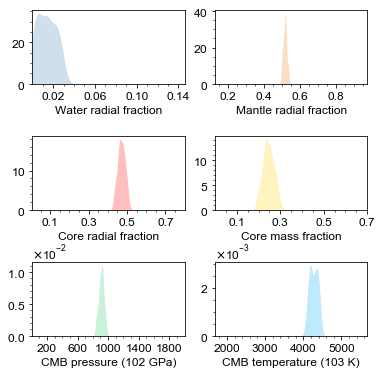

In [13]:
df_h1 = df_h[df_h['sigma_MRCk2']<=0.02]

inputs = ['Mass Earth_mass', 'Radius Earth_radius', 'Fe/(Si+Mg)', 'static Love number k2']
outputs = ['water radial frac', 'mantle radial frac', 'core radial frac', 'core mass frac', 'CMB press (GPa)', 'CMB temp (K)']

x_max = [
    1,
    1,
    1,
    1,
    1,
    1,
]
x_maxlabels = [
    y_min1+(y_max1-y_min1)*x_max[0],
    y_min2+(y_max2-y_min2)*x_max[1],
    y_min3+(y_max3-y_min3)*x_max[2],
    y_min4+(y_max4-y_min4)*x_max[3],
    y_min5+(y_max5-y_min5)*x_max[4],
    y_min6+(y_max6-y_min6)*x_max[5],
]

wrf = []  # H2O_radial_frac
mrf = []  # Mantle_radial_frac
crf = []  # Core_radial_frac
cmf = []  # Core mass frac
pcmb = []  # CMB temperature
tcmb = []  # CMB pressure


for x1 in np.arange(0.02,0.15,0.04):
    wrf.append((x1-y_min1)/(x_maxlabels[0]-y_min1)*x_max[0])
for x2 in np.arange(0.2,1,0.2):
    mrf.append((x2-y_min2)/(x_maxlabels[1]-y_min2)*x_max[1])
for x3 in np.arange(0.1,0.9,0.2):
    crf.append((x3-y_min3)/(x_maxlabels[2]-y_min3)*x_max[2])
for x4 in np.arange(0.1,0.8,0.2):
    cmf.append((x4-y_min4)/(x_maxlabels[3]-y_min4)*x_max[3])
for x5 in np.arange(200, 2000, 400):
    pcmb.append((x5-y_min5)/(x_maxlabels[4]-y_min5)*x_max[4])
for x6 in np.arange(2000, 6000, 1000):
    tcmb.append((x6-y_min6)/(x_maxlabels[5]-y_min6)*x_max[5])
    
xticklabels = [[round(x,2) for x in np.arange(0.02,0.15,0.04)],
               [round(x,2) for x in np.arange(0.2,1,0.2)],
               [round(x,2) for x in np.arange(0.1,0.9,0.2)],
               [round(x,2) for x in np.arange(0.1,0.8,0.2)],
               [round(x,2) for x in np.arange(200, 2000, 400)],
               [round(x,2) for x in np.arange(2000, 6000, 1000)],
              ]
xticks = [wrf, mrf, crf, cmf, pcmb, tcmb]
fig = plt.figure(figsize=(6,6))
fig.subplots_adjust(hspace=0.7, wspace=0.2)



x_max = [
    y_min1+(y_max1-y_min1)*1,
    y_min2+(y_max2-y_min2)*1,
    y_min3+(y_max3-y_min3)*1,
    y_min4+(y_max4-y_min4)*1,
    y_min5+(y_max5-y_min5)*1,
    y_min6+(y_max6-y_min6)*1,
]
for f in range(0,6):
    ax = fig.add_subplot(3, 2, f+1)
    y_min = locals()['y_min'+str(f+1)]
    y_max = locals()['y_max'+str(f+1)]
    print(y_max)
    sns.kdeplot(df_h1[outputs[f]], color=colors[f],fill=True,linewidth=0,bw_adjust=0.7,)
    ax.set_xlim(y_min, y_max)
    ax.set_ylim(bottom=0)
    
#     print(xticks[i])
#     xticklabels[i]

    ax.set_xticks(xticklabels[f])
#     ax.set_xticklabels(xticklabels[f])
    ax.set_xlabel(predict_label[f])
    ax.set_ylabel(None)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    formatter = tck.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True) 
    formatter.set_powerlimits((-2,2))
    ax.yaxis.set_major_formatter(formatter)
# plt.tight_layout()
# plt.savefig('MRCk2_phy_pred_HD3167b_20220925.pdf')